# Code for Fig. 4

In [2]:
%load_ext autoreload
%autoreload 1
%aimport general_functions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from tqdm.auto import tqdm
import copy

from general_functions import complete_dynamics, compute_shift

To compute the collective decay rate of a pair of emitters (or pair of clusters) we fit the time evolution of $\mathcal{P}_a(t) = \sum_{a_i}|C{a_i}(t)| ^2$ to the following equation

\begin{equation}
    \mathcal{P}_a(t) = 10^{-i\Gamma_\mathrm{coll}t}.
\end{equation}

## Free space (a, solid line)

In [4]:
pol_emi = np.array([[0, 1, 0]]).T

d = 1  # Wave-length of transition
lambda0 = d / 0.3  # Wave-length of transition
k0 = 2 * np.pi / lambda0

dt = 2e-3  # Time step
tf = dt * 2 ** 10  # Final time

psi0 = np.array([1, -1]) / np.sqrt(2)

In [62]:
n_de = 1000
de_vector = np.linspace(0.1, 22, n_de) * d

decays_free = np.zeros(n_de)

pbar = tqdm(total=n_de, desc='Computing dynamics')
for i in range(n_de): 
    emitter = [[de_vector[i] / 2, 0, 0],
               [-de_vector[i] / 2, 0, 0]]
    
    r_pos = [np.array([emi[coord] for emi in emitter]) for coord in range(3)]
    
    results = complete_dynamics(r_pos, k0, pol_emi, dt, tf, psi0)
    
    time = results['time']
    psi = results['psi']
    p_e = np.sum(np.abs(psi) ** 2, axis=-1)
    
    index0 = len(p_e) // 2
    
    fit = np.polyfit(time[index0:], np.log(p_e[index0:]), 1)
    alpha = fit[0]
    decays_free[i] = alpha
    
    pbar.update()    
pbar.close()

Computing dynamics:   0%|          | 0/1000 [00:00<?, ?it/s]

## Monolayer (a-b, blue circles)

In [69]:
pol_lat = np.array([[0, 1, 0]]).T
pol_emi = [np.array([[1, 1, 0]]).T / np.sqrt(2)] * 2

border = 15  # Border of adiabatic losses
gamma_max = 15  # Maximum individual free space decay rate in the border

N_x = 60
N_y = N_x
x_pos = (np.arange(0, N_x) - N_x / 2 + d / 2)
y_pos = (np.arange(0, N_y) - N_y / 2 + d / 2)
x_pos, y_pos = [x.flatten() for x in np.meshgrid(x_pos, y_pos)]
z_pos = np.zeros(np.shape(x_pos))
r_pos = [x_pos, y_pos, z_pos]

gamma_emi = 0.002
omega_emi = -0.999  # For d / lambda_0 = 0.3
n_e = len(pol_emi)

dt = 2e-3 / gamma_emi  # Time step
tf = dt * 2 ** 10  # Final time

emitter = [[-1, 1, 0], [1, -1, 0]]

signs = [1, 1]
psi0 = np.zeros(N_x * N_y + n_e, dtype=complex)
for i in range(n_e):
    psi0[-i - 1] = signs[i] / np.sqrt(n_e)

In [70]:
n_plaquettes = 7
distances_monolayer = np.zeros(n_plaquettes)
decays_monolayer = np.zeros(n_plaquettes)

pbar = tqdm(total=n_plaquettes, desc='Computing dynamics')
for i in range(n_plaquettes):
    # Move the emitters in a diagonal given by y = -x
    if i != 0:
        emitter[1][0] += 1
        emitter[1][1] -= 1
        emitter[0][0] -= 1
        emitter[0][1] += 1
        
    data = complete_dynamics(r_pos, k0, pol_lat, dt, tf, psi0, N_x, N_y, emitter, pol_emi,
                             gamma_emi, omega_emi, border, max_gamma=gamma_max)
    
    time = data['time']
    psi = data['psi']
    p_e = np.sum(np.abs(psi[:, -n_e:]) ** 2, axis=-1)
    
    distances_monolayer[i] = np.linalg.norm(np.array(emitter[0]) - np.array(emitter[1]))
    
    # Fit the decay rate of the emitters. The initial and final indices are needed so the system is
    # close to a steady state.
    index_i = 100
    index_f = len(time) // 3
    fit = np.polyfit(time[index_i:index_f] * gamma_emi, np.log(p_e[index_i:index_f]), 1)
    alpha = fit[0]
    
    decays_monolayer[i] = alpha
    
    pbar.update()    
pbar.close()

Computing dynamics:   0%|          | 0/7 [00:00<?, ?it/s]

## Two clusters (a-b, green triangles)

In [23]:
pol_lat = np.array([[0, 1, 0]]).T
pol_emi = [np.array([[1, 1, 0]]).T / np.sqrt(2)] * 4

n_e = len(pol_emi)

signs = [1, 1, 1, 1]
psi0 = np.zeros(N_x * N_y + n_e, dtype=complex)
for i in range(n_e):
    psi0[-i - 1] = signs[i] / np.sqrt(n_e)

omega_emi = -0.999  # For d / lambda_0 = 0.3
r_e = 0.45
theta_e = [3 * np.pi / 4]
theta_e.append(theta_e[0] + np.pi)
emitter = []
for theta in theta_e:
    emitter.append([1 + r_e * np.cos(theta), 1 + r_e * np.sin(theta), 0])
for theta in theta_e:
    emitter.append([-1 + r_e * np.cos(theta), -1 + r_e * np.sin(theta), 0])
    
shift = compute_shift(emitter[0], emitter[1], pol_emi[0], pol_emi[1], k0, gamma_emi, psi0[-2:])

In [24]:
n_plaquettes = 7
distances_cluster = np.zeros(n_plaquettes)
decays_cluster = np.zeros(n_plaquettes)

pbar = tqdm(total=n_plaquettes, desc='Computing dynamics')
for i in range(n_plaquettes):
    if i != 0:
        for k in range(2):
            emitter[k][0] += 1
            emitter[k][1] += 1
            emitter[k + 2][0] -= 1
            emitter[k + 2][1] -= 1
        
    data = complete_dynamics(r_pos, k0, pol_lat, dt, tf, psi0, N_x, N_y, emitter, pol_emi,
                             gamma_emi, omega_emi - np.real(shift), border, max_gamma=gamma_max)
    
    time = data['time']
    psi = data['psi']
    p_e = np.sum(np.abs(psi[:, -n_e:]) ** 2, axis=-1)
    
    mean1 = (np.array(emitter[0]) + np.array(emitter[1])) / 2
    mean2 = (np.array(emitter[2]) + np.array(emitter[3])) / 2
    distances_cluster[i] = np.linalg.norm(mean1 - mean2)

    index_i = 100
    index_f = len(time) // 3
    fit = np.polyfit(time[index_i:index_f] * gamma_emi, np.log(p_e[index_i:index_f]), 1)
    alpha = fit[0]
    
    decays_cluster[i] = alpha
    
    pbar.update()
pbar.close()

Computing dynamics:   0%|          | 0/7 [00:00<?, ?it/s]

## Bilayer (a-b, orange squares)

In [6]:
data = np.load('../data/divergence_energy_bilayer_shift.npy', allow_pickle=True).item()
omega_X_int = CubicSpline(data['z_vec'], data['omega_X'])

In [7]:
angle_target = 57.6 / 180 * np.pi

pol_lat = np.array([[1, 1, 0]]).T / np.sqrt(2)
pol_emi = [np.array([[0, 1, 0]]).T ] * 2

shift = np.array([0.5, 0.5, 0.1])  # Displacement vector

N_x = 50
N_y = N_x
x_pos_A = (np.arange(0, N_x) - N_x / 2 + d / 2)
y_pos_A = (np.arange(0, N_y) - N_y / 2 + d / 2)
x_pos_A, y_pos_A = np.meshgrid(x_pos_A, y_pos_A)
z_pos_A = np.zeros(np.shape(x_pos_A))

x_pos_B = shift[0] + x_pos_A[:-1, :-1]
y_pos_B = shift[1] + y_pos_A[:-1, :-1]
z_pos_B = shift[2] + z_pos_A[:-1, :-1]

x_pos_A = x_pos_A.flatten()
y_pos_A = y_pos_A.flatten()
n_A = len(x_pos_A)

x_pos_B = x_pos_B.flatten()
y_pos_B = y_pos_B.flatten()
n_B = len(x_pos_B)

x_pos = np.append(x_pos_A, x_pos_B)
y_pos = np.append(y_pos_A, y_pos_B)
z_pos = np.append(z_pos_A, z_pos_B)
r_pos = [x_pos, y_pos, z_pos]

omega_emi = omega_X_int(shift[2])
n_e = len(pol_emi)
emitter = [[1, 1 + 0.5, shift[2] / 2], [-1, -1 + 0.5, shift[2] / 2]]

signs = [1, 1]
psi0 = np.zeros(n_A + n_B + n_e, dtype=complex)
for i in range(n_e):
    psi0[-i - 1] = signs[i] / np.sqrt(n_e)

In [54]:
n_plaquettes = 5
distances_bilayer = np.zeros(n_plaquettes)
decays_bilayer = np.zeros(n_plaquettes)

pbar = tqdm(total=n_plaquettes, desc='Computing dynamics')
for i in range(n_plaquettes):
    if i != 0:
        emitter[0][0] += 1
        emitter[0][1] += 1
        emitter[1][0] -= 1
        emitter[1][1] -= 1
    
    # The emission in the bilayer case is not in 45º, so we move the emitter until reach to
    # an angle close to 57.6º.
    
    counter = 0
    while True:
        previous = copy.deepcopy(emitter)
        theta = np.arctan((emitter[0][1] - emitter[1][1]) / (emitter[0][0] - emitter[1][0]))
        if theta < angle_target:
            desp = -1
        else:
            desp = 1
        if counter % 2 == 0:
            emitter[1][1] += desp
        else:
            emitter[0][1] -= desp
        theta_new = np.arctan((emitter[0][1] - emitter[1][1]) / (emitter[0][0] - emitter[1][0]))
        if np.abs(theta_new - angle_target) > np.abs(theta - angle_target):
            emitter = previous[:]
            break
        else:
            counter += 1
            pass
    
    data = complete_dynamics(r_pos, k0, pol_lat, dt, tf, psi0, N_x, N_y, emitter, pol_emi,
                             gamma_emi, omega_emi, border, max_gamma=gamma_max)
    
    time = data['time']
    psi = data['psi']
    p_e = np.sum(np.abs(psi[:, -n_e:]) ** 2, axis=-1)
    
    distances_bilayer[i] = np.linalg.norm(np.array(emitter[0]) - np.array(emitter[1]))
    
    index_i = 10
    index_f = 300
    fit = np.polyfit(time[index_i:index_f] * gamma_emi, np.log(p_e[index_i:index_f]), 1)
    alpha = fit[0]
    
    decays_bilayer[i] = alpha
    
    pbar.update()    
pbar.close()

Computing dynamics:   0%|          | 0/5 [00:00<?, ?it/s]

## All cases

Text(0, 0.5, '$\\Gamma_\\mathrm{coll}/\\Gamma_\\mathrm{ind}$')

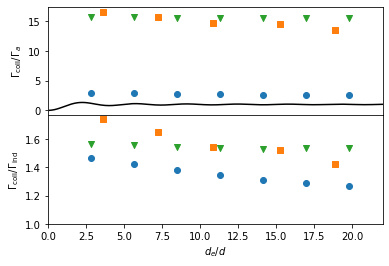

In [71]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)

ax1.plot(de_vector, -decays_free, 'k')
ax1.scatter(distances_monolayer, -decays_monolayer, marker='o')
ax1.scatter(distances_bilayer, -decays_bilayer, marker='s')
ax1.scatter(distances_cluster, -decays_cluster, marker='v')

ax1.set_xlim(0, 22)
ax1.set_ylabel(r'$\Gamma_\mathrm{coll}/\Gamma_a$')

ax2.scatter(distances_monolayer, -decays_monolayer / 2, marker='o')
ax2.scatter(distances_bilayer, -decays_bilayer / 9.54, marker='s')
ax2.scatter(distances_cluster, -decays_cluster / 10.09, marker='v')

ax2.set_ylim(1, ax2.get_ylim()[-1])
ax2.set_xlabel(r'$d_e / d$')
ax2.set_ylabel(r'$\Gamma_\mathrm{coll}/\Gamma_\mathrm{ind}$');